In [1]:
from mltools import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from wordcloud import WordCloud
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import trange

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

fig_num = 1
def fig_label(title, caption):
    global fig_num
    """
    Print figure caption on jupyter notebook
    """
    display(HTML(f"""<p style="font-size:14px;font-style:default;"><b>
                     Figure {fig_num}. {title}.</b><br>{caption}</p>"""))
    fig_num += 1
    
table_num = 2
def table_label(title, caption):
    global table_num
    """
    Print table caption on jupyter notebook
    """
    display(HTML(f"""<center style="font-size:14px;font-style:default;"><b>
                     Table {table_num}. {title}.</b><br>{caption}</center>""")
           )
    table_num += 1

d:\Universe\grassroots\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# What Influences Video Game Sales?

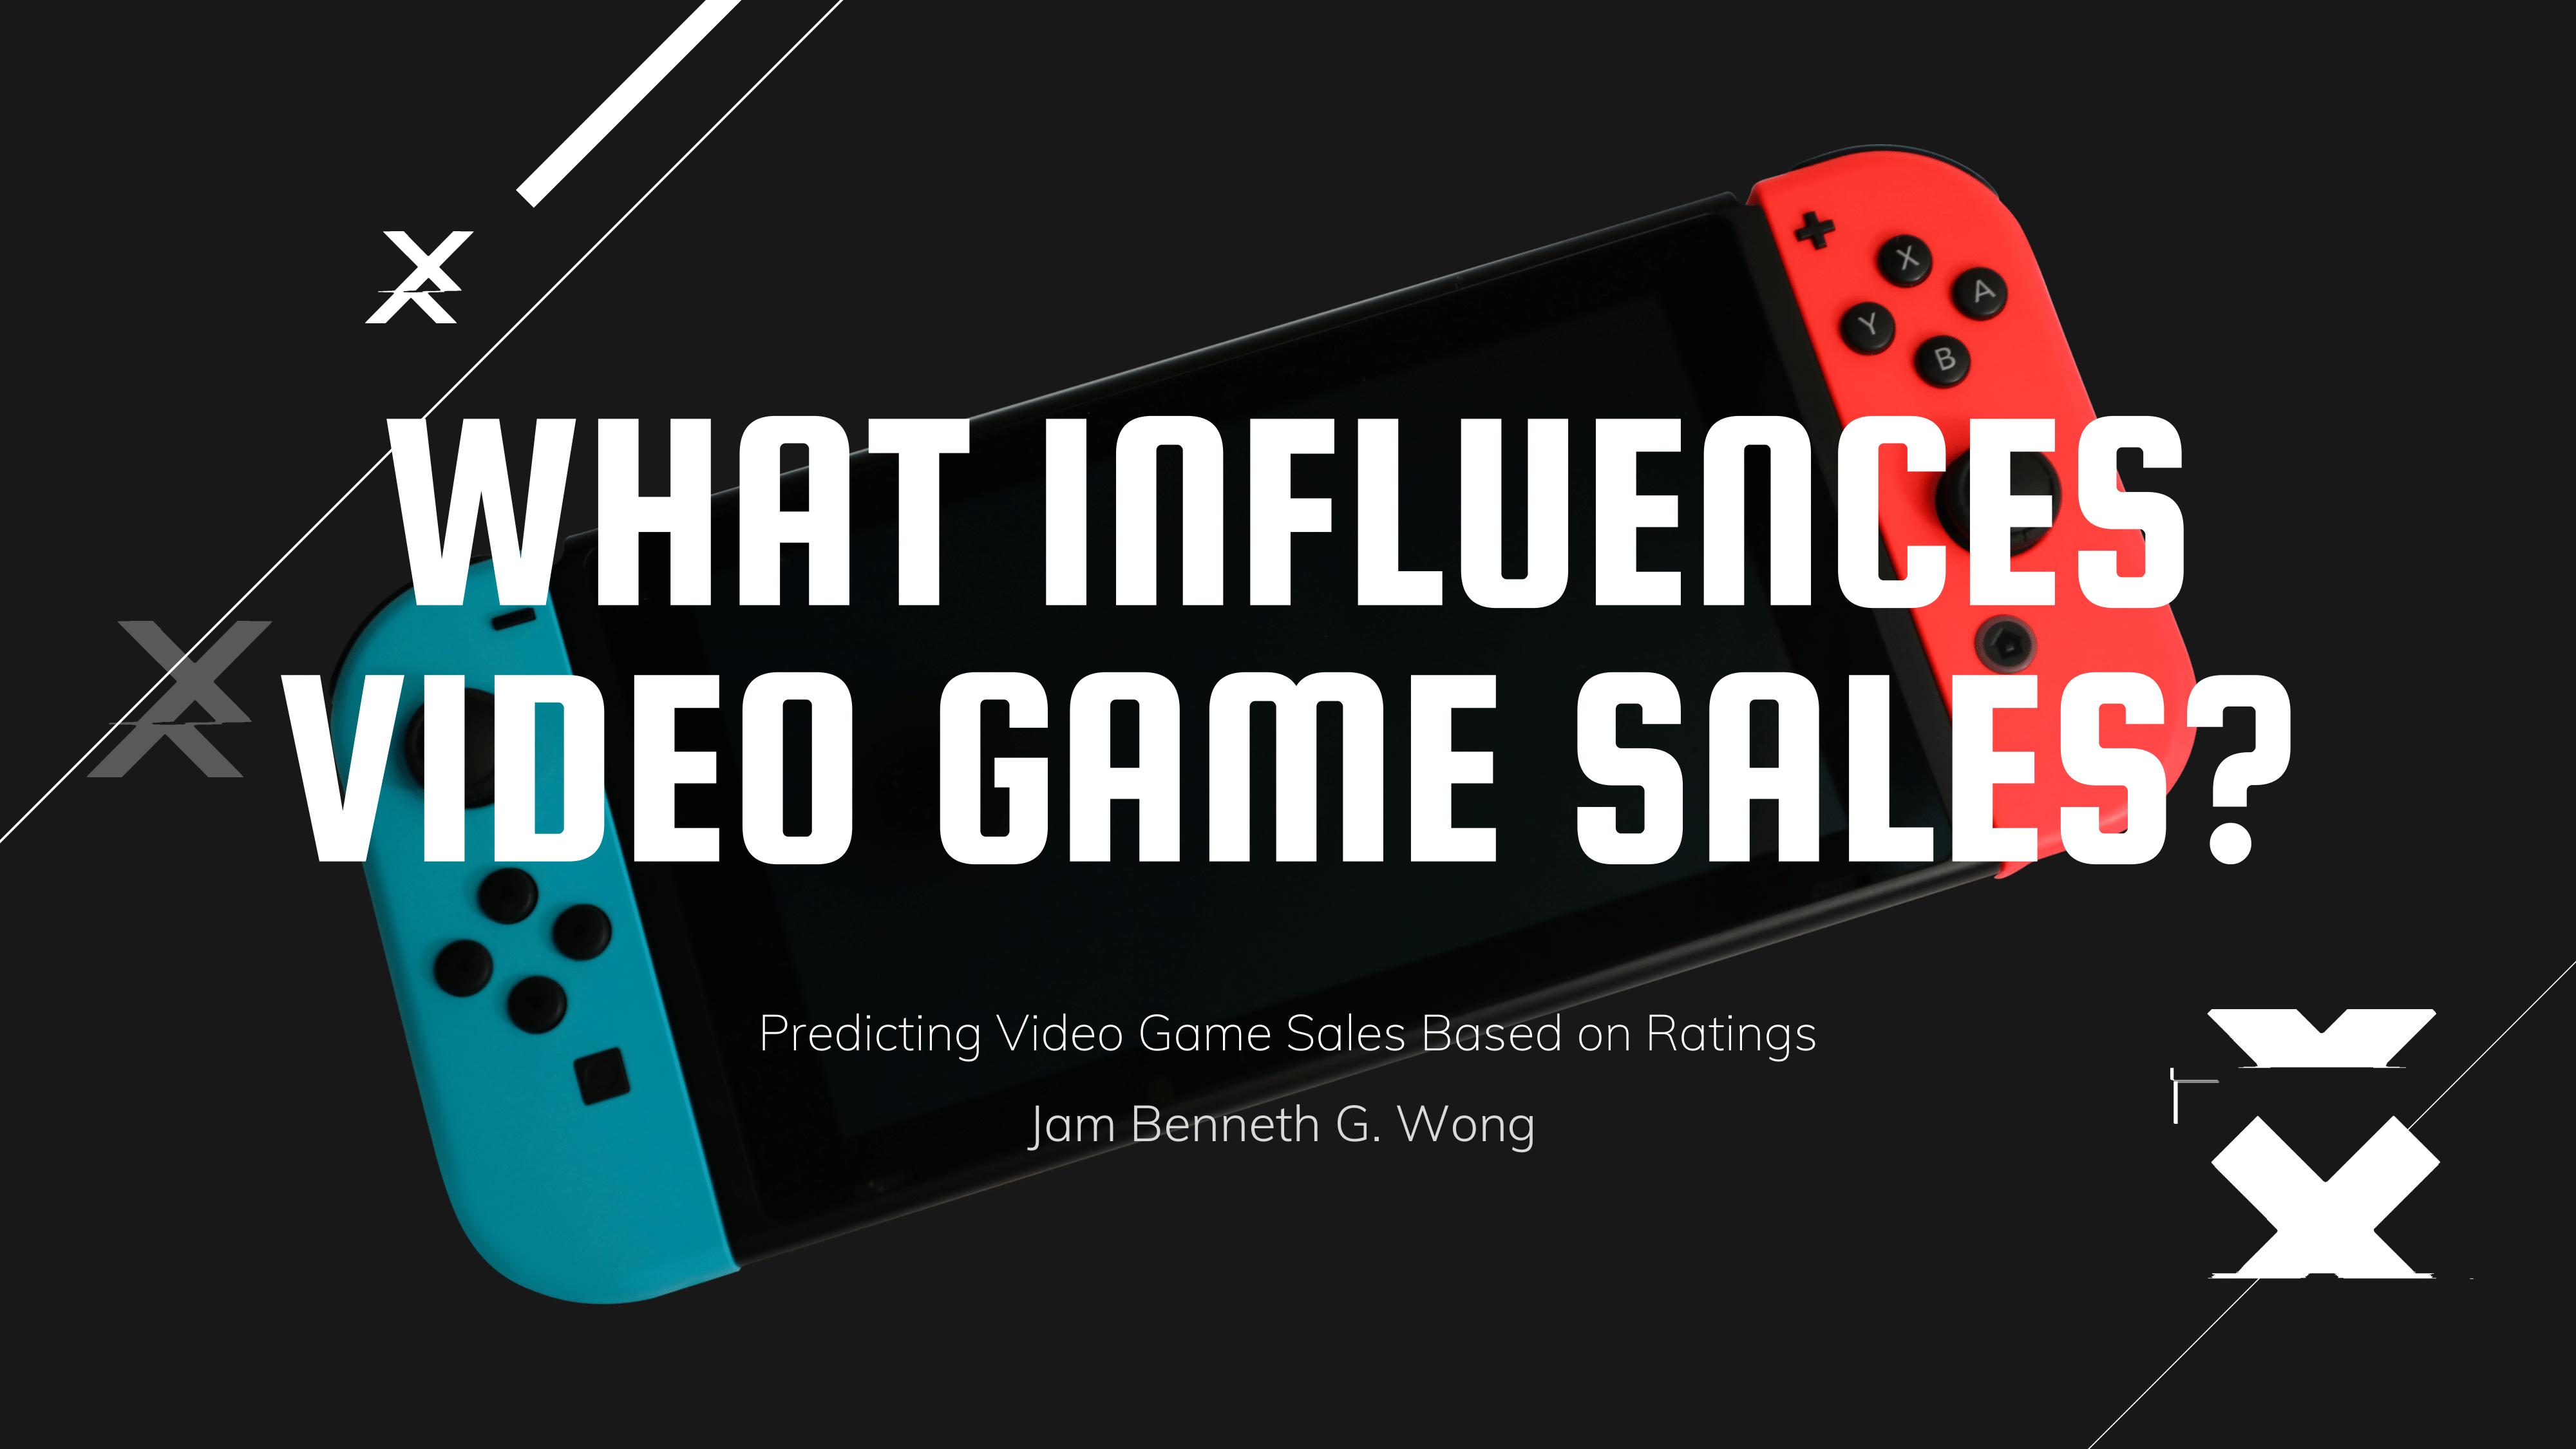

**Author**:
    Jam Benneth G. Wong

**Data Source**:
    Video Game Sales from Vgchartz with ratings from Metacritic [[1]](#data)

# Executive Summary

**Video games** are electronic games that involve interaction with an input device and an interface which generates visual feedback for the player. This usually comes in the form of a video display device such as TV or monitor. Video games are among the most interactive forms of entertainment and are also intertwined with technological advancement. Due to this, video games are popular among the youth and also adults who were youths during the beginning of the video game industry. Nevertheless, the video game industry also thrives in a business model, that is, it also aims to generate profit. 

In this study, we attempt to predict the sales of video games from its ratings. The dataset used in this study was obtained from Kaggle. In particular, we frame the problem in two situations:
- Video Game Sales Prediction via Regression
- Video Game Profitability Prediction via Classification

**Highlights.**
- Regression problems can be reframed to classification problems by binning the target variable.
- Ratings is one of the top predictors of video game sales but popularity is ranked higher.
- Publishers play an important role in the profitability of games.

# Methodology

## Problem Statement

<center> <b> Can we predict the profitability of video games based on its ratings? </center>

## Data Description

The `Video Games Sales with Ratings` dataset was obtained from Kaggle and was collected in 2016.

| Feature | Description | 
|:--------|:----------|
| `Name` | Game title |
| `Platform` | Platform of the games' release (PC,PS4, Wii, etc.) | 
| `Year` | Year of the game's release | 
| `Genre` | Genre of the game |
| `Developer` | Party responsible for creating the game |
| `Publisher` | Publisher of the game | 
| `NA_Sales` | Number of units sold in North America (in millions) |
| `EU_Sales` | Number of units sold (in millions) |
| `JP_Sales` | Number of units sold (in millions) |
| `Other_Sales` | Number of units sold in the rest of the world (in millions) |
| `Global_Sales` | Total Number of units sold (in millions) |
| `Critic_Score` | Aggregate score compiled by Metacritic staff | 
| `Critic_Count` | Number of critics used to come up with the Criticscore |
| `User_Score` | Aggregate Score by Metacritic subscribers |
| `User_Count` | Number of Metacritic subscribers who scored the game | 
| `Rating` | ESRB ratings |

<center> <b> Table 1. Data Dictionary of the Video Game Sales Dataset</b></center>

## Exploratory Data Analysis and Data Preprocessing

### Data Cleaning

First, we load the data at look and the data types, the number of unique values, as well as missing values for each feature.

In [2]:
raw = pd.read_csv('video_game_sales_2016-12-22.csv')

display(HTML(
    '<center>'+pd.concat(
        [raw.dtypes.rename('dtypes'), raw.nunique().rename('unique_values'),
         raw.isna().sum().rename('null')],
        axis=1).to_html()+'</center>'
))
table_label('Data Types, Unique Values, and Missing Values of each Feature'
            ' in the Dataset',
            '')

,dtypes,unique_values,null
Name,object,11562,2
Platform,object,31,0
Year_of_Release,float64,39,269
Genre,object,12,2
Publisher,object,581,54
NA_Sales,float64,402,0
EU_Sales,float64,307,0
JP_Sales,float64,244,0
Other_Sales,float64,155,0
Global_Sales,float64,629,0


Unfortunately, a lot of the games in the original dataset scraped from VGChartz do not have ratings in Metacritic. Since we primarily want to predict using ratings, we drop games with missing data. Moreover, there are categorical variables that have more than $1000$ unique labels and are not readily usable as predictors. We retain the `Publisher` column here for reasons that will be explained during feature engineering. There are also five sales columns which we can use as our target variable. For this project, we will attempt to predict `Global_Sales` based on the ratings.

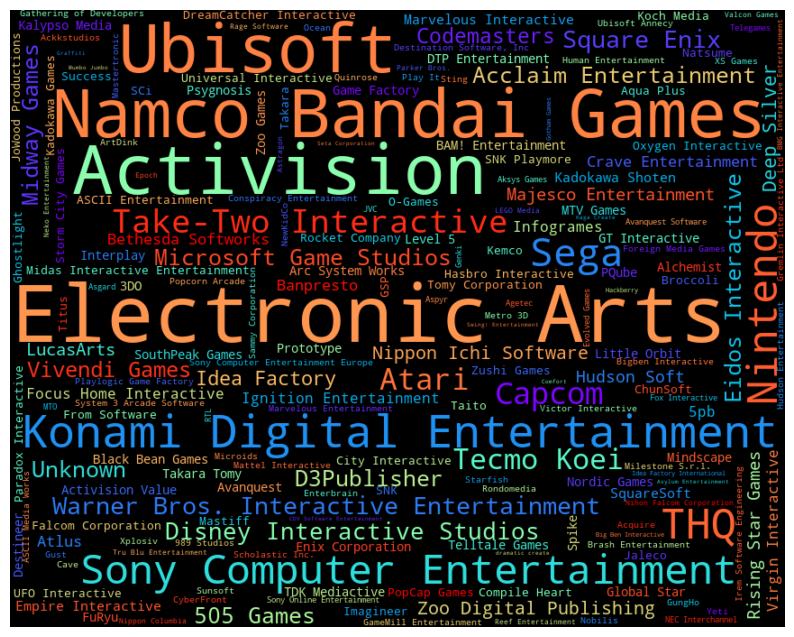

In [3]:
mask = np.array(Image.open('mask.png'))
wc = WordCloud(
    background_color='black',
    max_words=200,
    collocations = False,
    mask=mask,
    contour_color='#023075',
    contour_width=3,
    colormap='rainbow',
    random_state=4
).generate_from_frequencies(raw.Publisher.value_counts())
fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(wc, interpolation="bilinear")
ax.axis('off')
plt.show()

fig_label('Word Cloud of Publishers in the Dataset',
          'Electronic Arts, Activion, Namco Bandai Games, and Ubisoft are '
          'among the top publishers in the dataset.')

We drop the unnecessary columns and retain only those with potential as predictors for the machine learning implementation.

In [4]:
raw = raw.dropna().reset_index(drop=True)
raw['User_Score'] = raw['User_Score'].astype('float')
raw['Year_of_Release'] = raw['Year_of_Release'].astype('int')

drop_cols = ['Name', 'Platform', 'NA_Sales', 'EU_Sales',
             'JP_Sales', 'Other_Sales', 'Developer', 'Genre']

vg_sales = raw.drop(columns=drop_cols)

display(HTML(
    '<center>'+vg_sales.head().to_html(index=False)+'</center>'
))

Year_of_Release,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
2006,Nintendo,82.53,76.0,51.0,8.0,322.0,E
2008,Nintendo,35.52,82.0,73.0,8.3,709.0,E
2009,Nintendo,32.77,80.0,73.0,8.0,192.0,E
2006,Nintendo,29.80,89.0,65.0,8.5,431.0,E
2006,Nintendo,28.92,58.0,41.0,6.6,129.0,E


### Visualization

We divide the `Global_Sales` to three bins from low, mid, and high `Profitability` to better visualize where the best-selling games lie in the plot. We see from the pair plot below that low profitability games have high variability when plotted against other features.

d:\Universe\grassroots\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Universe\grassroots\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Universe\grassroots\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Universe\grassroots\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical

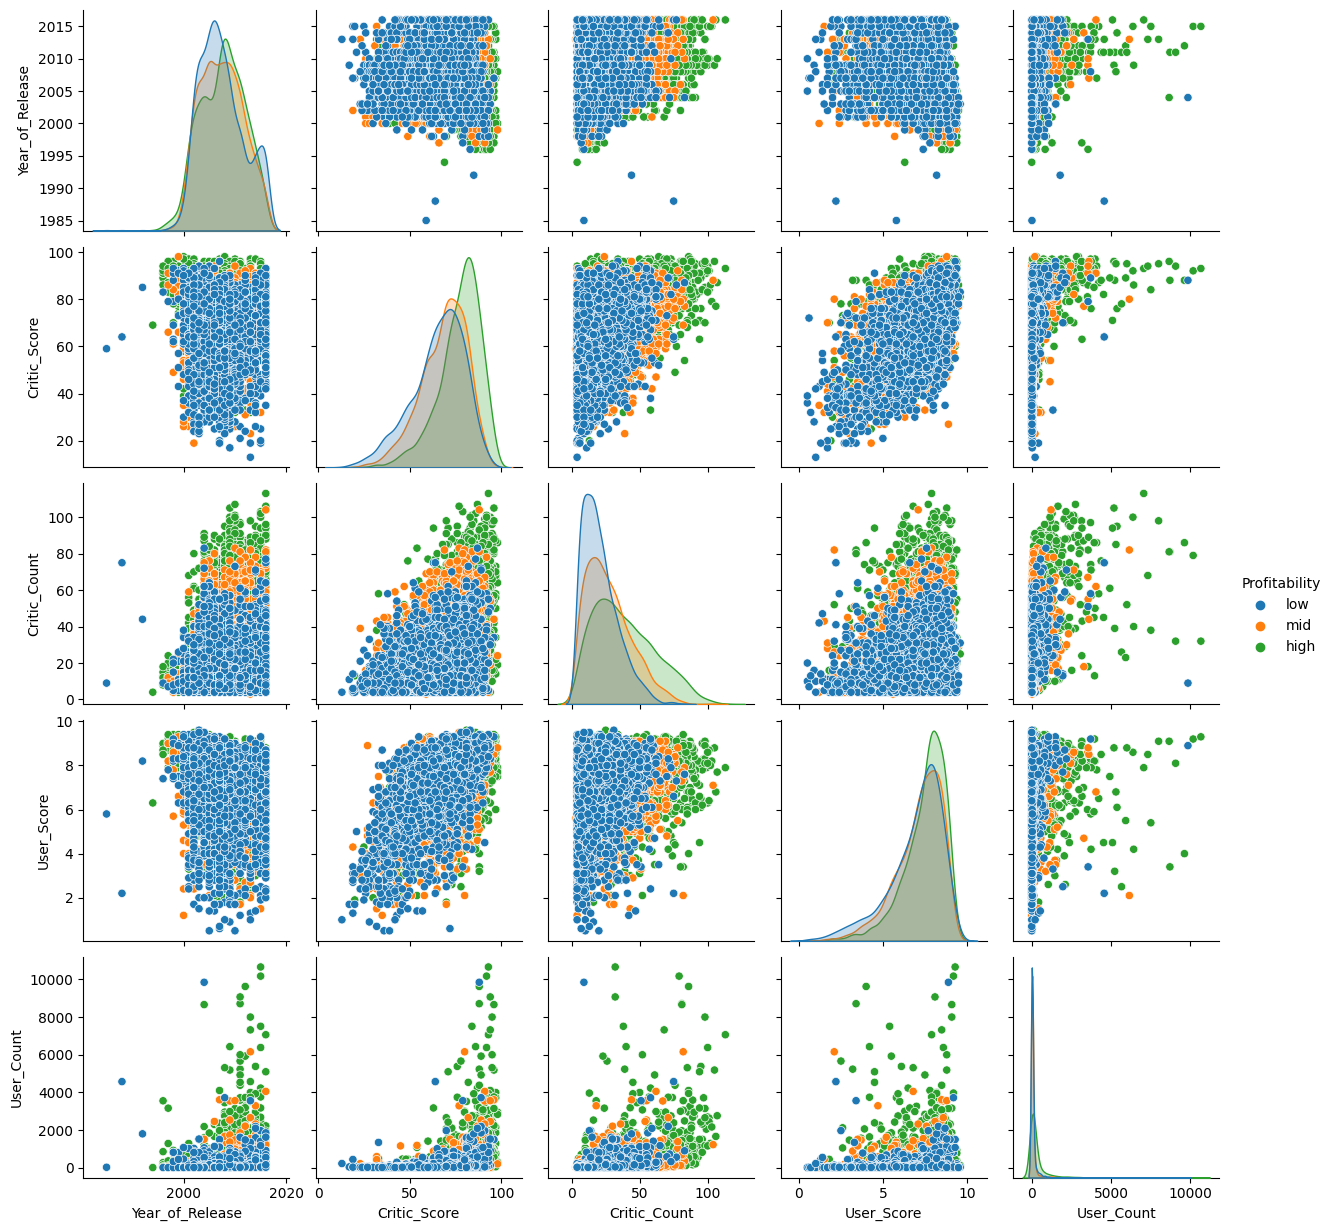

In [5]:
vg_sales['Profitability'] = pd.cut(
    x=raw.Global_Sales,
    bins=[0,
          raw.Global_Sales.quantile(1/3),
          raw.Global_Sales.quantile(2/3),
          raw.Global_Sales.max()],
    labels=['low', 'mid', 'high']
)

pair_plot = sns.pairplot(vg_sales[[
    'Year_of_Release',
    'Critic_Score',
    'Critic_Count',
    'User_Score',
    'User_Count',
    'Profitability'
]], hue='Profitability')
plt.show()

fig_label('Pairplot of Numerical Features in the Dataset',
          'Low profitability games have high variance across all features.')

From the heatmap below, the features do not appear to be highly correlated.

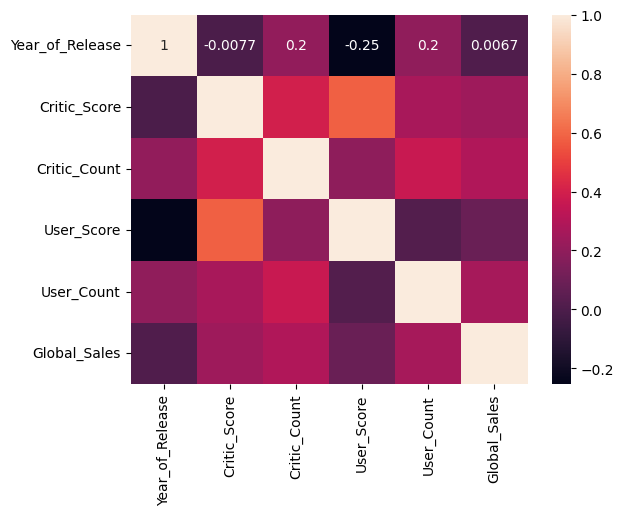

In [6]:
heatmap = sns.heatmap(vg_sales[[
    'Year_of_Release',
    'Critic_Score',
    'Critic_Count',
    'User_Score',
    'User_Count',
    'Global_Sales'
]].corr(), annot=True)
plt.show()

fig_label('Heatmap of Numerical Features in the Dataset',
          'There does not appear to be a significantly high correlation '
          'between any two features.')

### Transformation of Target Variable

Next, we look at the distribution of the target variable `Global_Sales`. Notice on the left plot below that the data is drastically skewed to the right. Due to this, we convert the Global Sales into log-scale and predict this target instead.

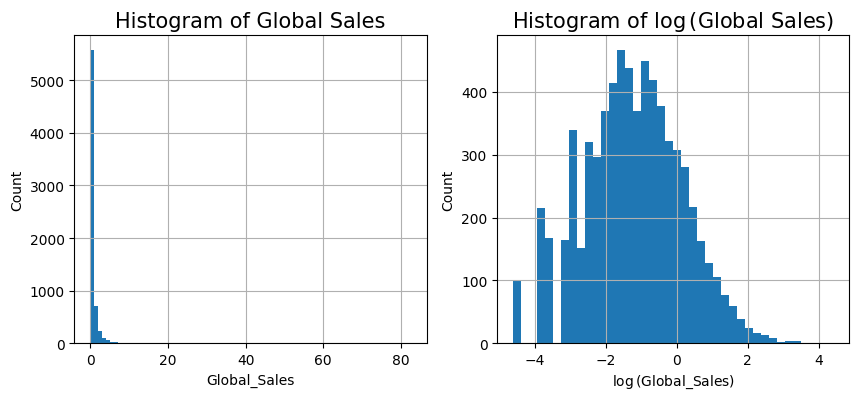

In [7]:
vg_sales['log_Sales'] = vg_sales.Global_Sales.apply(np.log)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vg_sales.Global_Sales.hist(bins=80, ax=ax[0])
ax[0].set_title('Histogram of Global Sales', fontsize=15)
ax[0].set_xlabel('Global_Sales')
ax[0].set_ylabel('Count')
vg_sales.log_Sales.hist(bins=40, ax=ax[1])
ax[1].set_title('Histogram of $\log$(Global Sales)', fontsize=15)
ax[1].set_xlabel('$\log$(Global_Sales)')
ax[1].set_ylabel('Count')
plt.show()

fig_label('Distribution of the Target Variable',
          'Global Sales is distributed in an exponentially decaying manner '
          'which hints at using $\log$-transformation.')

The transformed target variable now looks more reasonably distributed. This will help improve the accuracy of predictions later on. Next, we explore feature engineering from the various predictors in the dataset.

## Feature Engineering

Based on the author's domain knowledge, we note that `Publisher`s play an important role in the sales of games as they are the entity in the video game industry that controls the distribution of games across the globe. And so we retain the `Publisher` feature and utilize other numerical features for feature engineering. In order to capture the behavior of sales with respect to `Publisher`s, we create four new features as follows.

| Feature | Description | 
|:--------|:----------|
| `Publisher_Ave_Critic_Score` | Mean `Critic_Score` of a publisher |
| `Publisher_Ave_User_Score` | Mean `User_Score` of a publisher | 
| `Games_Published` | Number of games published by the publisher | 
| `Age` | How old the game is in years |

In [8]:
vg_sales['Age'] = 2016 - vg_sales['Year_of_Release']

ave_critic_sales = (vg_sales.groupby('Publisher')['Critic_Score']
                    .mean().rename('Publisher_Ave_Critic_Score')
                    .reset_index())
ave_user_sales = (vg_sales.groupby('Publisher')['User_Score']
                  .mean().rename('Publisher_Ave_User_Score')
                  .reset_index())
num_games_pub = (vg_sales.groupby('Publisher')['Profitability']
                 .size().rename('Games_Published')
                 .reset_index())

vg_sales = vg_sales.merge(ave_critic_sales, on='Publisher', how='left')
vg_sales = vg_sales.merge(ave_user_sales, on='Publisher', how='left')
vg_sales = vg_sales.merge(num_games_pub, on='Publisher', how='left')

display(HTML(
    '<center>'+vg_sales.head().to_html(index=False)+'</center>'
))

table_label('Processed Dataset for Machine Learning',
          'This is the dataset that will be fed to the machine learning '
          'models for prediction.')

Year_of_Release,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Profitability,log_Sales,Age,Publisher_Ave_Critic_Score,Publisher_Ave_User_Score,Games_Published
2006,Nintendo,82.53,76.0,51.0,8.0,322.0,E,high,4.413162,10,76.237113,7.92268,291
2008,Nintendo,35.52,82.0,73.0,8.3,709.0,E,high,3.570096,8,76.237113,7.92268,291
2009,Nintendo,32.77,80.0,73.0,8.0,192.0,E,high,3.489513,7,76.237113,7.92268,291
2006,Nintendo,29.80,89.0,65.0,8.5,431.0,E,high,3.394508,10,76.237113,7.92268,291
2006,Nintendo,28.92,58.0,41.0,6.6,129.0,E,high,3.364533,10,76.237113,7.92268,291


The dataset is now ready to be used as input to the machine learning pipeline in the next section.

## Model Selection

In this section, we will run the processed dataset through an auto-ML pipeline and choose the model with the highest validation accuracy. First, we set aside $10\%$ of our datapoints as our test set and run the training set through a grid search. We scale the features using `RobustScaler` as this scaling method is the most reliable for data with outliers.

In [9]:
num_feat = ['Age', 'Critic_Count', 'Critic_Score', 'User_Count',
            'User_Score']
cat_feat = ['Rating']
feat_eng = ['Publisher_Ave_Critic_Score', 'Publisher_Ave_User_Score',
            'Games_Published']
targets = ['log_Sales', 'Profitability']

X = pd.get_dummies(vg_sales[num_feat+cat_feat+feat_eng])
y = vg_sales[targets]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1
)

### Regression on Video Game Prices

Below is the code to train machine learning models using the data. The dataset is passed through a pipeline which transforms the training data using `RobustScaler`. We use five regressor models namely

1. `KNeighborsRegressor`

2. `Ridge`

3. `Lasso`

4. `RandomForestRegressor`

5. `GradientBoostingRegressor`.

We then pass these models inside a `GridSearchCV` to perform hyperparameter tuning and `KFold` cross validation in one go. After the grid search finishes, we append the essential metrics to a summary table which will be shown in the results.

In [10]:
# tqdm progress bar format
bar = {'bar_format': '{l_bar}{bar:50}{r_bar}{bar:-10b}'}

# Define the parameter grids
knn_params = {'reg__n_neighbors': np.arange(1, 21)}
linear_params = {'reg__alpha':
                 [1e-5, 1e-4, 1e-3, .01, 0.1, 0.2, 0.4, 0.75,1, 1.5, 3, 5,
                  10, 15, 20, 100, 1000, 5000, 10000, 50000, 100000]}
rf_params = {
    'reg__max_depth': np.arange(5, 12),
}
gbm_params = {
    'reg__max_depth': np.arange(5, 12),
    'reg__learning_rate': np.linspace(0.01, 2, 8)
}

models = [
    ('kNN', KNeighborsRegressor(), knn_params),
    ('Ridge', Ridge(max_iter=100_000), linear_params),
    ('Lasso', Lasso(max_iter=100_000), linear_params),
    ('Random Forest', RandomForestRegressor(), rf_params),
    ('Gradient Boosting', GradientBoostingRegressor(), gbm_params)
]

auto_ml_headers = ['Model', 'Train MAE', 'Validation MAE', 'Best Parameters',
                   'Top Predictor', 'Run Time']
auto_ml_results = []

In [11]:
fitted_model = {}
plotting_importances = {}
for i, (name, regressor, params) in enumerate(tqdm(models, **bar)):

    # Instantiate the pipeline and grid search.
    steps = [('scaler', RobustScaler()), ('reg', regressor)]
    pipe = Pipeline(steps)
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        n_jobs=-1,
        cv=5,
        scoring='neg_mean_absolute_error',
        return_train_score=True,
    )

    # Fit the model.
    grid_search.fit(X_trainval, y_trainval['log_Sales'])
    fitted_model.update({name: grid_search})
    
    # Get the results.
    results = grid_search.cv_results_
    train_mae = results['mean_train_score'].mean()
    val_mae = results['mean_test_score'].mean()
    run_time = results['mean_fit_time'].mean()

    # Get the top predictors (coef_ for linear models, feature_importances_
    # for tree-based models)
    
    if name in ['Ridge', 'Lasso']:
        best_params = (f"$\\alpha$ = "
                       f"{grid_search.best_params_['reg__alpha']}")
        feature_importances = np.abs(grid_search
                                     .best_estimator_
                                     .steps[1][1]
                                     .coef_)
        importance_idx = feature_importances.argsort()[::-1]
        top_predictor = X.columns[importance_idx[0]]
        plotting_importances.update({name:
                                     (feature_importances, importance_idx)})
    elif name in ['Random Forest', 'Gradient Boosting']:
        best_params = ("Max Depth = "
                       f"{grid_search.best_params_['reg__max_depth']}")
        feature_importances = (grid_search
                               .best_estimator_
                               .steps[1][1]
                               .feature_importances_)
        importance_idx = feature_importances.argsort()[::-1]
        top_predictor = X.columns[importance_idx[0]]
        plotting_importances.update({name:
                                     (feature_importances, importance_idx)})
    else:
        best_params = ("$n_\text{neighbors}$ = "
                       f"{grid_search.best_params_['reg__n_neighbors']}")
        top_predictor = 'N/A'
    
    auto_ml_results.append(
        [name, np.exp(1)**train_mae, np.exp(1)**val_mae, best_params,
         top_predictor, run_time]
    )
    
summary_table = pd.DataFrame(auto_ml_results, columns=auto_ml_headers)

100%|██████████████████████████████████████████████████| 5/5 [04:59<00:00, 59.96s/it]


### Classification on Video Game Profitability

Likewise, for the classification problem, the dataset is passed through a pipeline which transforms the training data using `RobustScaler`. We use five classifiers namely

1. `KNeighborsClassifier`

2. `LogisticRegression` ($L1$ and $L2$)

3. `LinearSVC` ($L1$ and $L2$)

4. `RandomForestClassifier`

5. `GradientBoostingClassifier`.

We then pass these models inside a `GridSearchCV` to perform hyperparameter tuning and `KFold` cross validation in one go. After the grid search finishes, we append the essential metrics to a summary table which will be shown in the results.

In [12]:
use_methods = ['kNN', 'Logistic (L1)', 'Logistic (L2)', 'SVM (L1)',
               'SVM (L2)', 'RF Classifier', 'GB Classifier']

# Train and test models
c = MLModels.run_classifier(X_trainval, y_trainval['Profitability'],
                            X_trainval.columns,
                            task='C',
                            n_neighbors=list(range(1, 21)),
                            C=[0.01, 0.1, 0.2, 0.4, 0.75, 1, 100],
                            max_depth=list(range(5, 12)),
                            use_methods=use_methods,
                            n_trials=10,
                            tree_rs=1337,
                            scaling='robust')

Training and testing: kNN model


Iter: 10: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Training and testing: Logistic (L1) model


Iter: 10: 100%|██████████| 70/70 [00:04<00:00, 15.61it/s]


Training and testing: Logistic (L2) model


Iter: 10: 100%|██████████| 70/70 [00:02<00:00, 24.66it/s]


Training and testing: SVM (L1) model


Iter: 10: 100%|██████████| 70/70 [00:10<00:00,  6.76it/s]


Training and testing: SVM (L2) model


Iter: 10: 100%|██████████| 70/70 [00:03<00:00, 21.45it/s]


Training and testing: RF Classifier model


Iter: 10: 100%|██████████| 70/70 [01:03<00:00,  1.11it/s]


Training and testing: GB Classifier model


Iter: 10: 100%|██████████| 70/70 [14:17<00:00, 12.25s/it]


# Results and Discussion

## Regression on Video Game Prices

In this section we will highlight the results of the regression model training and derive insights from them.

### Summary Table

In [13]:
display(HTML(
    '<center>'+summary_table.to_html(index=False)+'</center>'
))

table_label('Summary Table for Regression on Video Game Sales',
            'The validation mean absolute error is lowest for the Gradient '
            'Boosting model with critic count as the top predictor.')

Model,Train MAE,Validation MAE,Best Parameters,Top Predictor,Run Time
kNN,0.475518,0.402106,$n_\text{neighbors}$ = 9,N/A,0.117705
Ridge,0.388071,0.386944,$\alpha$ = 100,Critic_Count,0.092775
Lasso,0.342625,0.342162,$\alpha$ = 0.001,Critic_Count,0.153188
Random Forest,0.494037,0.435359,Max Depth = 11,Critic_Count,6.386313
Gradient Boosting,0.733023,0.241512,Max Depth = 5,Critic_Count,6.209659


It appears that Gradient Boosting has the lowest validation mean absolute error, so we choose this model and retrain it using the whole training and validation set. We scale our data using the same scaling used in the grid search and transform `X_trainval` and `X_test` accordingly.

In [14]:
scaling = RobustScaler().fit(X_trainval)

gbr = GradientBoostingRegressor(
    max_depth=5,
    learning_rate=(fitted_model['Gradient Boosting']
                   .best_params_['reg__learning_rate']),
    random_state=1337
)

gbr.fit(
    pd.DataFrame(scaling.transform(X_trainval), columns=X_trainval.columns),
    y_trainval['log_Sales']
)
y_pred = gbr.predict(
    pd.DataFrame(scaling.transform(X_test), columns=X_trainval.columns)
)

mae = mean_absolute_error(y_test['log_Sales'], y_pred)

In [15]:
joblib.dump(gbr, 'GradientBoostingRegressor.pkl')

print(f'The test mean absolute error for the Gradient Boosting Classifier is '
      f'{mae:.4f} units.')

The test mean absolute error for the Gradient Boosting Classifier is 0.7904 units.


We save the fitted `GradientBoostingRegressor` model to a `.pkl` file for future use. From this result, it is evident that the model does not generalize well based on the three-fold increase of the test MAE with respect to the validation MAE. Hence, we attempt to reframe the problem as a classification task instead of regression in the next section.

### Feature Importances

Next we check the feature importances by plotting coefficients obtained from the `best_estimator_` in the grid search.

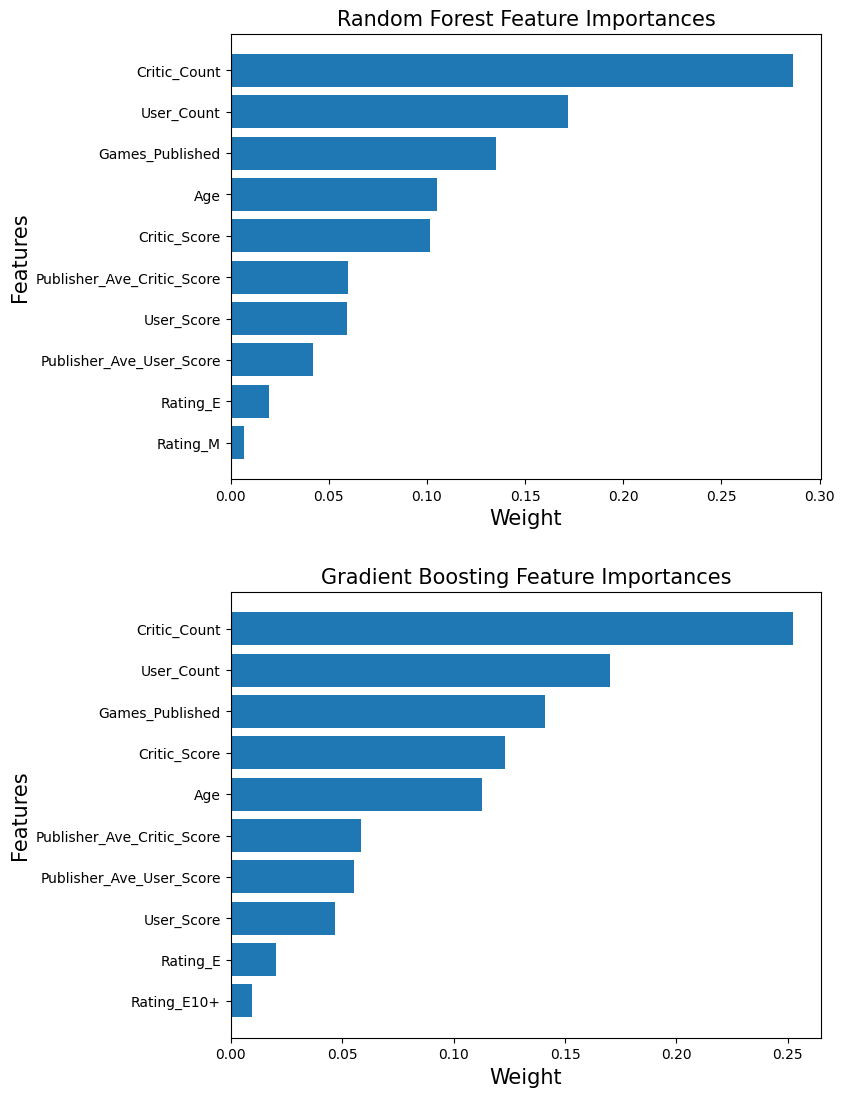

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
fig.tight_layout(pad=6)
ax = ax.flatten()

for i, (name, (feature_importances, importance_idx)) \
    in enumerate(list(plotting_importances.items())[2:]):
    ax[i].barh(
                width=feature_importances[importance_idx[:10]][::-1],
                y=X.columns[importance_idx[:10]][::-1]
            )
    ax[i].set_title(f'{name} Feature Importances', fontsize=15)
    ax[i].set_xlabel('Weight', fontsize=15)
    ax[i].set_ylabel('Features', fontsize=15)
plt.show()

fig_label('Feature Importance Plot of the Top 2 Performing Regression Models',
          'Critic count, user count, and the number of games published are'
          'consistent top predictors.')

`Critic_Count`, `User_Count`, and `Games_Published` are the top predictors for this problem. This implies that counts are more important than actual ratings, and publishers also have a more significant influence on sales than `User_Score`.

## Classification on Video Game Profitability

In this section we will highlight the results of the classifier model training and derive insights from them.

### Summary Table

In [17]:
MLModels.summarize(c, X_trainval.columns, show_top=True);

table_label('Summary Table for Classification on Video Game Profitability',
            'The validation accuracy is highest for the Gradient '
            'Boosting model with user count as the top predictor.')

Model,Train Accuracy,Test Accuracy,Best Parameter,Train Time,Top Predictor
kNN,61.60%,53.46%,$n_\text{neighbors} = 13$,0.02 secs,NA
Logistic (L1),52.34%,52.52%,$C = 0.01$,0.02 secs,Rating_AO
Logistic (L2),52.60%,52.70%,$C = 0.01$,0.03 secs,Rating_E
SVM (L1),52.10%,52.25%,$C = 0.01$,0.03 secs,Rating_E
SVM (L2),52.22%,52.15%,$C = 0.01$,0.04 secs,Rating_E
RF Classifier,88.05%,60.01%,Max Depth= 11,0.61 secs,User_Count
GB Classifier,90.95%,60.17%,Max Depth= 6,6.55 secs,User_Count


The test accuracy column above is actually the validation accuracy for our problem. From the results, it appears that the tree-based methods provide the highest accuracy. Let us now refit the whole train and validation set to our best model `GradientBoostingClassifier` with `max_depth=5` and check the accuracy for our hold-out test set. We scale our data using the same scaling used in the grid search and transform `X_trainval` and `X_test` accordingly.

In [19]:
scaling = RobustScaler().fit(X_trainval)
gbc = GradientBoostingClassifier(max_depth=5, random_state=1337)

gbc.fit(
    pd.DataFrame(scaling.transform(X_trainval), columns=X_trainval.columns),
    y_trainval['Profitability']
)
test_acc = gbc.score(
    pd.DataFrame(scaling.transform(X_test), columns=X_trainval.columns),
    y_test['Profitability']
)

In [20]:
joblib.dump(gbc, 'GradientBoostingClassifier.pkl')

pcc = ((y['Profitability'].value_counts() / len(y)) ** 2).sum()

print(f'The test accuracy for the Gradient Boosting Classifier is '
      f'{test_acc*100:.2f}% which beats the proportional chance criterion '
      f'at {pcc*100:.2f}%.')

The test accuracy for the Gradient Boosting Classifier is 61.93% which beats the proportional chance criterion at 33.35%.


The resulting test accuracy above is slightly higher than the validation accuracy. This may be attributed to chance based on the splitting of the data prior to model selection. Nevertheless,

### Feature Importances

The best performing Gradient Boosting Classifier estimator has the following feature importance plot. The high importances of the `User_Count` and `Critic_Count` features suggest that based on the data, the top predictor of video game profitability is actually the number of users interacting with a game. `Games_Published` which is a proxy for publisher, also rates high for feature importance, hinting that the size of a publisher's portfolio contributes to the sales of its published games. In contrast, ESRB ratings have low feature importance, which suggests that flagging games for certain ages do not really affect its sales.

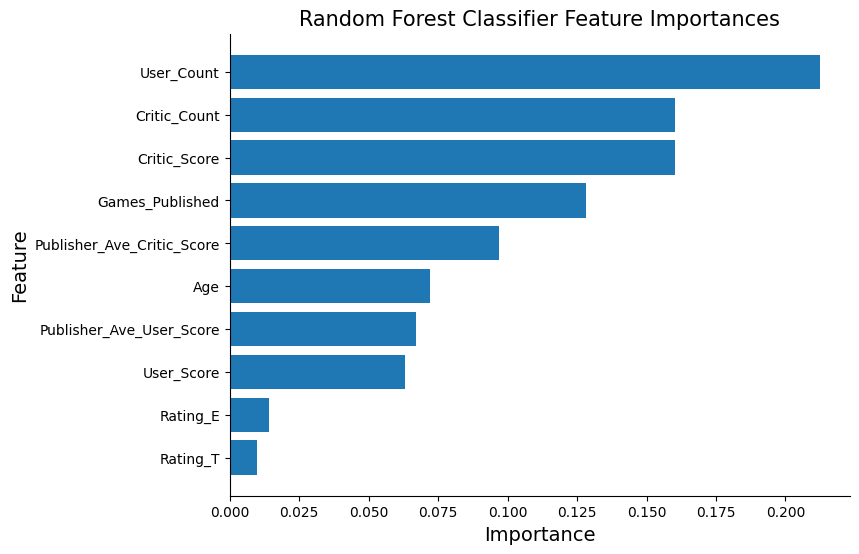

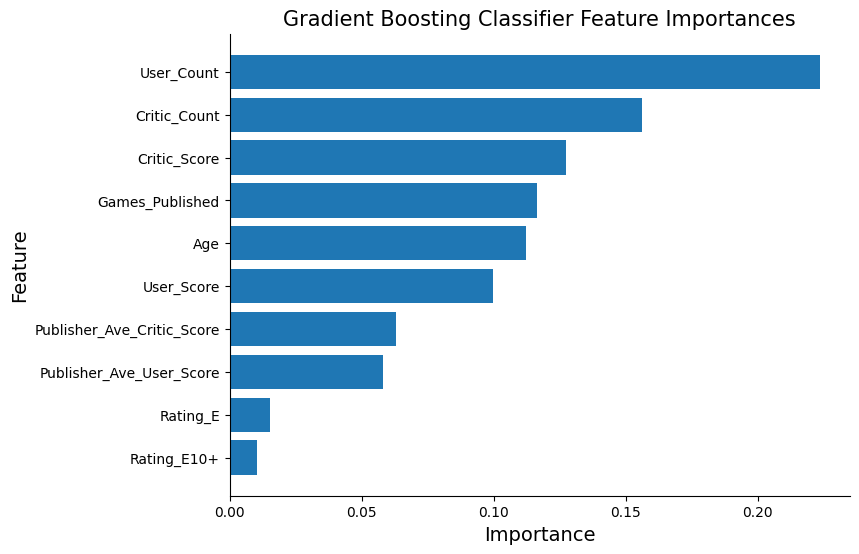

In [21]:
c['RF Classifier'].plot_feature_importance(feature_names=X.columns)
plt.title('Random Forest Classifier Feature Importances', fontsize=15)
c['GB Classifier'].plot_feature_importance(feature_names=X.columns)
plt.title('Gradient Boosting Classifier Feature Importances', fontsize=15)
plt.show()

fig_label('Feature Importance Plot of the Top 2 Performing Classification '
          'Models',
          'Critic count, user count, and the number of games published are'
          'consistent top predictors.')

### Predicting Probabilities

`predict_proba` is a method in Classifiers that quantifies a model's uncertainty in its prediction. Below we plot the probability distributions of the first five games in the test set to illustrate this. However, depending on the model used, the output of `predict_proba` may be biased and it must be calibrated via `CalibratedClassifierCV`. We show its implementation in the second plot below.

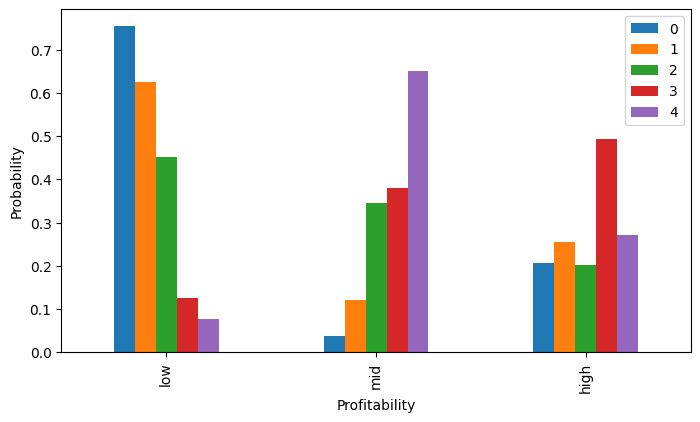

In [23]:
fig, ax = plt.subplots(figsize=(7, 4))
fig.tight_layout(pad=1)
pd.DataFrame(gbc.predict_proba(
    pd.DataFrame(scaling.transform(X_test), columns=X_trainval.columns)),
    columns=['low', 'mid', 'high']
).T.iloc[:, :5].plot.bar(ax=ax)
ax.set_xlabel('Profitability')
ax.set_ylabel('Probability')
plt.show()

fig_label('Probability Distributions of the First Five Games in the Test '
          'Set',
          'The model is most uncertain in classifying the profitability of '
          'Game 2.')

Below we pass our fitted model to a `CalibratedClassifierCV` instance and fit it data that our model has not seen before, that is, the test set. These steps result to a calibrated classifier whose `predict_proba` outputs we can trust better. We similarly plot the probability distributions of the first five games in the test set.

In [25]:
clf_sigmoid = CalibratedClassifierCV(gbc, cv=2, method='sigmoid')

clf_sigmoid.fit(
    pd.DataFrame(scaling.transform(X_test), columns=X_trainval.columns),
    y_test['Profitability']
);

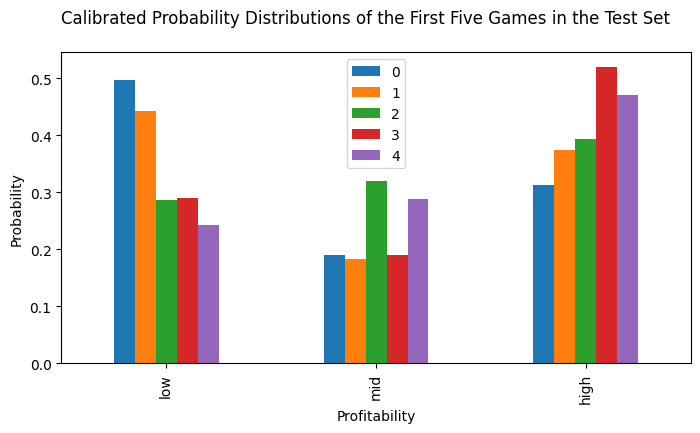

In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
fig.suptitle('Calibrated Probability Distributions of the First Five Games in'
             ' the Test Set')
fig.tight_layout(pad=1)
pd.DataFrame(clf_sigmoid.predict_proba(
    pd.DataFrame(scaling.transform(X_test), columns=X_trainval.columns)),
    columns=['low', 'mid', 'high']
).T.iloc[:, :5].plot.bar(ax=ax)
ax.set_xlabel('Profitability')
ax.set_ylabel('Probability')
plt.show()

fig_label('Calibrated Probability Distributions of the First Five Games in '
          'the Test Set',
          'The model is most uncertain in classifying the profitability of'
          ' Game 2.')

# Conclusion and Recommendations

To summarize, we implemented a machine learning algorithm to predict the profitability of video games based on features such as score, publisher, and user counts. The problem was tackled in two angles: regression and classification. In regression, we predicted the $\log$ of global sales of a game and although the best model has a good validation accuracy, it failed to generalize well in the test set. So we also attempted to reframe the problem to classification.

In both situations, the top two predictors are between `User_Score` and `Critic_Score`. This suggests that rating may not be as important to sales as popularity. This means that should game developers aim to generate the most amount of sales, they must endeavor to bring awareness to their games via marketing. Towards this end, we also highlight the importance of publishers. We performed feature engineering to create numerical features representing the publishers of the game. `Games_Published` appear to influence the sales of a game as well.

For further improvements, the author recommends to acquire more data and explore further feature engineering to properly capture the relationship of publishers with games. Though the classification results show promise, a downside to this reframing is that the ordinality of the target variable is lost after this transformation. Ordinal classifiers may be explored further to find more appropriate model for the problem.

# Acknowledgements

The author would like to acknowledge his ML1 mentor, Leodegario Lorenzo for his guidance in this project as well as for sharing his `mltools` package for easy automation of the machine learning pipeline used for model selection in the classification task.

# References

<a name='data'></a>[1] Video Game Sales with Ratings. (2016, December 22) https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings